In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

# some constants
kB = 1.380649 * 10**-23    # Boltzmann (m^2 kg / s^2 K)
h = 6.62607 * 10**-34      # Planck (m^2 kg / s)
R = 1.9858775 * 10**-3     # universal gas (kcal / mol K)

plt.rcParams['text.usetex'] = True

In [2]:
# make some guesses on parameters
delta = 200 # 200 Angstrom thickness
lam = 2 # 2 Angstrom jumps

# read in the experimental data
df = pd.read_csv('csv_data/experimental_data.csv')

# calculate some useful columns
df['1/T'] = 1/df['T (K)']
df['ln(P)'] = np.log(df['B (m/sec)'])
df['ln(P/T)'] = np.log(df['B (m/sec)']/df['T (K)'])
df['ln(CP/T)'] = np.log(df['B (m/sec)']*delta*h/lam**2/kB/df['T (K)'])

df1 = df[df['system'] == 'NaCl (NF270)']
df2 = df[df['system'] == 'NaF (NF270)'].reset_index(drop=True)
df3 = df[df['system'] == 'NaCl (RO)'].reset_index(drop=True)
df4 = pd.read_csv('csv_data/experimental_data_water.csv')

### Testing different OLS fits

$\ln{P} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{P} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R}$

But, the intercept still has a temperature dependence...

In [3]:
T = df1['T (K)']
P = df1['B (m/sec)']

# perform linear fit of ln(P) vs 1/T
X = sm.add_constant(1/T)
ols1 = sm.OLS(np.log(P), X)
results1 = ols1.fit()
b, m = results1.params
be, me = results1.bse

print('ln(P) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')

print(results1.summary())

ln(P) vs 1/T:
Arrhenius barrier to permeability, Ea: 4.17 +/- 0.94 kcal/mol
Arrhenius prefactor, ln(A): -3.36 +/- 1.58 A/s
                            OLS Regression Results                            
Dep. Variable:              B (m/sec)   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     19.75
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           0.000987
Time:                        11:59:27   Log-Likelihood:                 3.8064
No. Observations:                  13   AIC:                            -3.613
Df Residuals:                      11   BIC:                            -2.483
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


$\ln{\frac{P}{T}} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\frac{P}{T}} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R}$

In [4]:
T = df1['T (K)']
P = df1['B (m/sec)']

# perform linear fit of ln(P/T) vs 1/T
X = sm.add_constant(1/T)
ols2 = sm.OLS(np.log(P/T), X)
results2 = ols2.fit()
b, m = results2.params
be, me = results2.bse

print('ln(P/T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')

print(results2.summary())

ln(P/T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.57 +/- 0.94 kcal/mol
Arrhenius prefactor, ln(A): -10.06 +/- 1.58 A/s
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     14.50
Date:                Fri, 05 Jan 2024   Prob (F-statistic):            0.00290
Time:                        11:59:27   Log-Likelihood:                 3.8007
No. Observations:                  13   AIC:                            -3.601
Df Residuals:                      11   BIC:                            -2.471
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


$\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \frac{\Delta S_{eff}}{R}$

In [5]:
T = df1['T (K)']
P = df1['B (m/sec)']

# perform linear fit of ln(P*delta*h/lam^2*kB*T) vs 1/T
X = sm.add_constant(1/T)
ols3 = sm.OLS(np.log(P*delta*h/lam**2/kB/T), X)
results3 = ols3.fit()
b, m = results3.params
be, me = results3.bse

print('ln(P*delta*h/lam^2*kB*T) vs 1/T:')
print(f'Arrhenius barrier to permeability, Ea: {-m*R:.2f} +/- {me*R:.2f} kcal/mol')
print(f'Arrhenius prefactor, ln(A): {b:.2f} +/- {be:.2f} A/s')

print(results3.summary())

ln(P*delta*h/lam^2*kB*T) vs 1/T:
Arrhenius barrier to permeability, Ea: 3.57 +/- 0.94 kcal/mol
Arrhenius prefactor, ln(A): -29.91 +/- 1.58 A/s
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     14.50
Date:                Fri, 05 Jan 2024   Prob (F-statistic):            0.00290
Time:                        11:59:27   Log-Likelihood:                 3.8007
No. Observations:                  13   AIC:                            -3.601
Df Residuals:                      11   BIC:                            -2.471
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

/Users/nate_schwindt/anaconda3/envs/mpipy/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


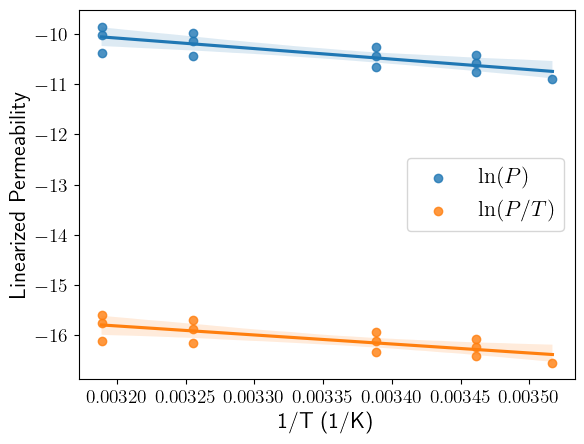

In [6]:
# plot the linear fits
fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T', y='ln(P)', data=df1, ax=ax, label='$\ln (P)$', ci=95)
sns.regplot(x='1/T', y='ln(P/T)', data=df1, ax=ax, label='$\ln (P/T)$', ci=95)
# sns.regplot(x='1/T', y='ln(CP/T)', data=df1, ax=ax, label='$\ln \left( P \delta h/ \lambda^2 k_B T \\right)$', ci=95)

plt.ylabel('Linearized Permeability', fontsize=16)
plt.xlabel('1/T (1/K)', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params('both', labelsize=14)

fig.savefig('figs/TST_vs_Arrhenius_plots.png')

### Replicate the experimental plots in the paper with error

In [7]:
# generate the barrier data with error for plotting
barriers = pd.DataFrame()
barriers['system'] = ['NaCl (water)', 'NaCl (NF270)', 'NaF (NF270)', 'NaCl (RO)']

# do the analysis for NaCl in water as well
X = sm.add_constant(1/df4['T (K)'])
ols = sm.OLS(np.log(df4['Conductivity (uS/cm)'] / df4['T (K)']), X)
results = ols.fit()
b, m = results.params
be, me = results.bse

slopes = [m]
slope_err = [me]
intercepts = [b]
intercept_err = [be]
dH = [-m*R]
dH_err = [me*R]

# perform linear regression and save the standard error
for tmp in [df1,df2,df3]:
    
    X = sm.add_constant(1/tmp['T (K)'])
    ols = sm.OLS(np.log(tmp['B (m/sec)'] / tmp['T (K)']), X)
    results = ols.fit()
    b, m = results.params
    be, me = results.bse

    slopes.append(m)
    slope_err.append(me)
    intercepts.append(b)
    intercept_err.append(be)
    dH.append(-m*R)
    dH_err.append(me*R)

barriers['slope'] = slopes
barriers['slope error'] = slope_err
barriers['intercept'] = intercepts
barriers['intercept error'] = intercept_err
barriers['effective enthalpy'] = dH
barriers['error'] = dH_err
barriers

,system,slope,slope error,intercept,intercept error,effective enthalpy,error
0,NaCl (water),-1435.501957,217.894579,3.873470,0.705947,2.850731,0.432712
1,NaCl (NF270),-1799.340862,472.487912,-10.063829,1.578287,3.573271,0.938303
2,NaF (NF270),-1973.858688,562.175156,-10.206582,1.886499,3.919842,1.116411
3,NaCl (RO),-2243.359707,675.416337,-10.390132,2.262707,4.455038,1.341294


In [8]:
# check that the statsmodels bse is the same as the propagated error
X = sm.add_constant(1/df1['T (K)'])
ols = sm.OLS(np.log(df1['B (m/sec)'] / df1['T (K)']), X)
results = ols.fit()

s = np.sqrt(results.ssr / (len(df1['B (m/sec)']) - 2))
N = np.linalg.inv(np.dot(X.T, X))
var = N.diagonal()*s**2
np.sqrt(var)

array([  1.57828653, 472.487912  ])

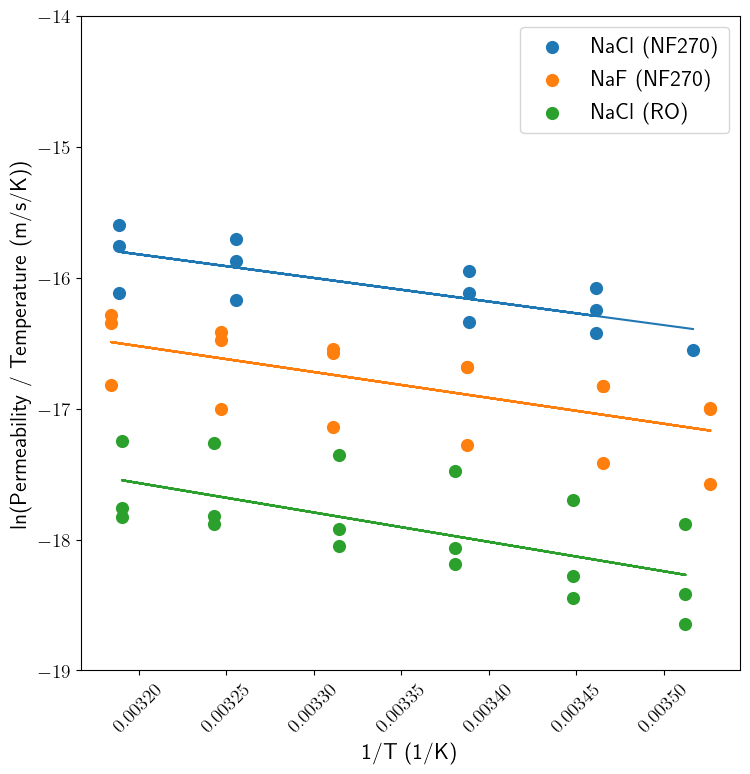

In [9]:
# plot ln(P/T) vs 1/T, which would correspond to the TST model
systems = ['NaCl (NF270)', 'NaF (NF270)', 'NaCl (RO)']
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(1,1, figsize=(8.5,8.5))

# plot the TST linear regression plots
for sys,c in zip(systems,colors):
    tmp = df[df['system'] == sys]

    # perform linear regression for plotting
    X = sm.add_constant(tmp['1/T'])
    ols = sm.OLS(tmp['ln(P/T)'], X)
    res = ols.fit()
    b, m = res.params

    # plot the linear regression and the data points with error
    ax.plot(tmp['1/T'], m*tmp['1/T']+b, color=c)
    ax.scatter(tmp['1/T'], tmp['ln(P/T)'],
               marker='o', label=sys, lw=0, color=c, s=90)

ax.set_ylim(-19, -14)
ax.set_ylabel('ln(Permeability / Temperature (m/s/K))', fontsize=16)
ax.set_xlabel('1/T (1/K)', fontsize=16)
ax.tick_params('x', labelsize=14, labelrotation=45)
ax.tick_params('y', labelsize=14)
ax.legend(loc='best', fontsize=16)

fig.savefig('figs/experimental_TST_plots.pdf')

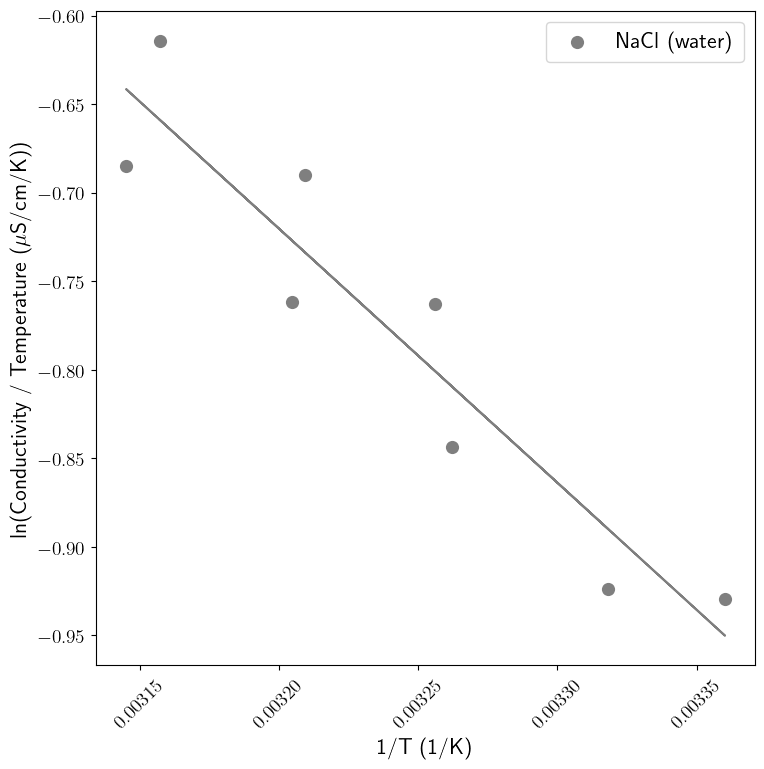

In [17]:
# plot ln(P/T) vs 1/T for the NaCl in water
fig, ax = plt.subplots(1,1, figsize=(8.5,8.5))

# perform linear regression for plotting
X = sm.add_constant(1/df4['T (K)'])
ols = sm.OLS(np.log(df4['Conductivity (uS/cm)'] / df4['T (K)']) , X)
res = ols.fit()
b, m = res.params

# plot the linear regression and the data points with error
ax.plot(1/df4['T (K)'], m*(1/df4['T (K)'])+b, color='tab:gray')
ax.scatter(1/df4['T (K)'], np.log(df4['Conductivity (uS/cm)'] / df4['T (K)']),
            marker='o', label='NaCl (water)', lw=0, color='tab:gray', s=90)

ax.set_ylabel('ln(Conductivity / Temperature ($\mu$S/cm/K))', fontsize=16)
ax.set_xlabel('1/T (1/K)', fontsize=16)
ax.tick_params('x', labelsize=14, labelrotation=45)
ax.tick_params('y', labelsize=14)
ax.legend(loc='best', fontsize=16)

fig.savefig('figs/NaCl_in_water_TST.pdf')


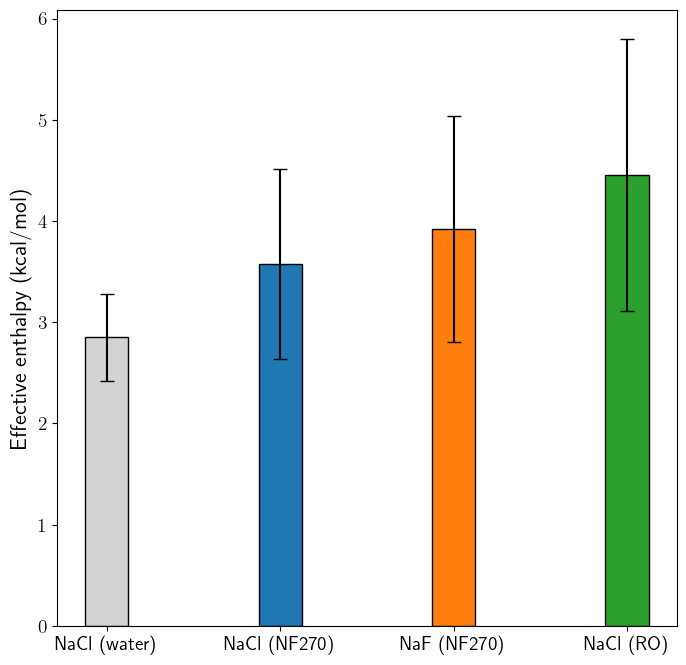

In [ ]:
# plot the barriers with errors
fig, ax = plt.subplots(1,1, figsize=(8,8))

bar_colors = ['lightgray', 'tab:blue', 'tab:orange', 'tab:green']
ax.bar(barriers['system'], barriers['effective enthalpy'], yerr=barriers['error'],
          color=bar_colors, edgecolor='k', width=0.25, capsize=5)
ax.set_ylabel('Effective enthalpy (kcal/mol)', fontsize=16)
ax.tick_params('both', labelsize=14)

fig.savefig('figs/experimental_Ea.pdf')

#### The same plot using the Arrhenius equation rather than the TST equation

In [ ]:
# generate the barrier data with error for plotting
barriers = pd.DataFrame()
barriers['system'] = ['NaCl (water)', 'NaCl (NF270)', 'NaF (NF270)', 'NaCl (RO)']

# do the analysis for NaCl in water as well
X = sm.add_constant(1/df4['T (K)'])
ols = sm.OLS(np.log(df4['Conductivity (uS/cm)'] / df4['T (K)']), X)
results = ols.fit()
b, m = results.params
be, me = results.bse

slopes = [m]
slope_err = [me]
intercepts = [b]
intercept_err = [be]
dH = [-m*R]
dH_err = [me*R]

# perform linear regression and save the standard error
for tmp in [df1,df2,df3]:
    
    X = sm.add_constant(1/tmp['T (K)'])
    ols = sm.OLS(np.log(tmp['B (m/sec)']), X)
    results = ols.fit()
    b, m = results.params
    be, me = results.bse

    slopes.append(m)
    slope_err.append(me)
    intercepts.append(b)
    intercept_err.append(be)
    dH.append(-m*R)
    dH_err.append(me*R)

barriers['slope'] = slopes
barriers['slope error'] = slope_err
barriers['intercept'] = intercepts
barriers['intercept error'] = intercept_err
barriers['effective enthalpy'] = dH
barriers['error'] = dH_err
barriers

,system,slope,slope error,intercept,intercept error,effective enthalpy,error
0,NaCl (water),-1435.501957,217.894579,3.873470,0.705947,2.850731,0.432712
1,NaCl (NF270),-2099.094300,472.278838,-3.360272,1.577588,4.168544,0.937888
2,NaF (NF270),-2272.007312,562.163004,-3.508355,1.886458,4.511928,1.116387
3,NaCl (RO),-2542.017156,675.264938,-3.690275,2.262199,5.048135,1.340993


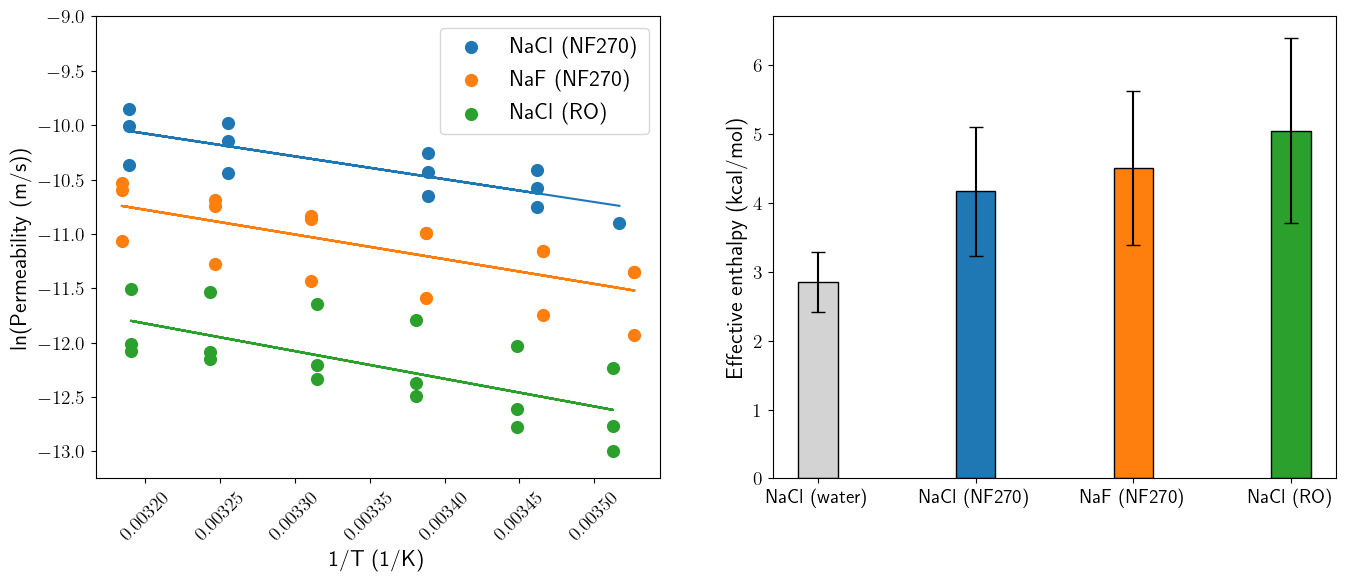

In [ ]:
# plot ln(P) vs 1/T, which would correspond to the Arrhenius model
systems = ['NaCl (NF270)', 'NaF (NF270)', 'NaCl (RO)']
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(1,2, figsize=(16,6))

# plot the TST linear regression plots
for sys,c in zip(systems,colors):
    tmp = df[df['system'] == sys]

    # perform linear regression for plotting
    X = sm.add_constant(tmp['1/T'])
    ols = sm.OLS(tmp['ln(P)'], X)
    res = ols.fit()
    b, m = res.params

    # plot the linear regression and the data points with error
    ax[0].plot(tmp['1/T'], m*tmp['1/T']+b, color=c)
    ax[0].scatter(tmp['1/T'], tmp['ln(P)'],
                 marker='o', label=sys, lw=0, color=c, s=90)

ax[0].set_ylim(-13.25, -9)
ax[0].set_ylabel('ln(Permeability (m/s))', fontsize=16)
ax[0].set_xlabel('1/T (1/K)', fontsize=16)
ax[0].tick_params('x', labelsize=14, labelrotation=45)
ax[0].tick_params('y', labelsize=14)
ax[0].legend(loc='best', fontsize=16)

# plot the barriers errors
bar_colors = ['lightgray', 'tab:blue', 'tab:orange', 'tab:green']
ax[1].bar(barriers['system'], barriers['effective enthalpy'], yerr=barriers['error'],
          color=bar_colors, edgecolor='k', width=0.25, capsize=5)
ax[1].set_ylabel('Effective enthalpy (kcal/mol)', fontsize=16)
ax[1].tick_params('both', labelsize=14)